In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
import plaidml.keras
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
plaidml.keras.install_backend()
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [2]:

df = pd.read_excel("../data/Abbottabad/carbon monoxide.xlsx")
df = df[['Sensor Value']]
df

,Sensor Value
0,637
1,637
2,634
3,637
4,631
...,...
1018,835
1019,835
1020,831
1021,831


In [3]:
Days = pd.date_range(start="2017-09-07",end="2020-06-25")

In [4]:
dataframe = pd.DataFrame()
dataframe['ds'] = Days
dataframe['ds'] = dataframe['ds'].dt.date
dataframe['y'] = df[['Sensor Value']]
dataframe

,ds,y
0,2017-09-07,637
1,2017-09-08,637
2,2017-09-09,634
3,2017-09-10,637
4,2017-09-11,631
...,...,...
1018,2020-06-21,835
1019,2020-06-22,835
1020,2020-06-23,831
1021,2020-06-24,831


In [5]:

dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      1023 non-null   object
 1   y       1023 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 16.1+ KB


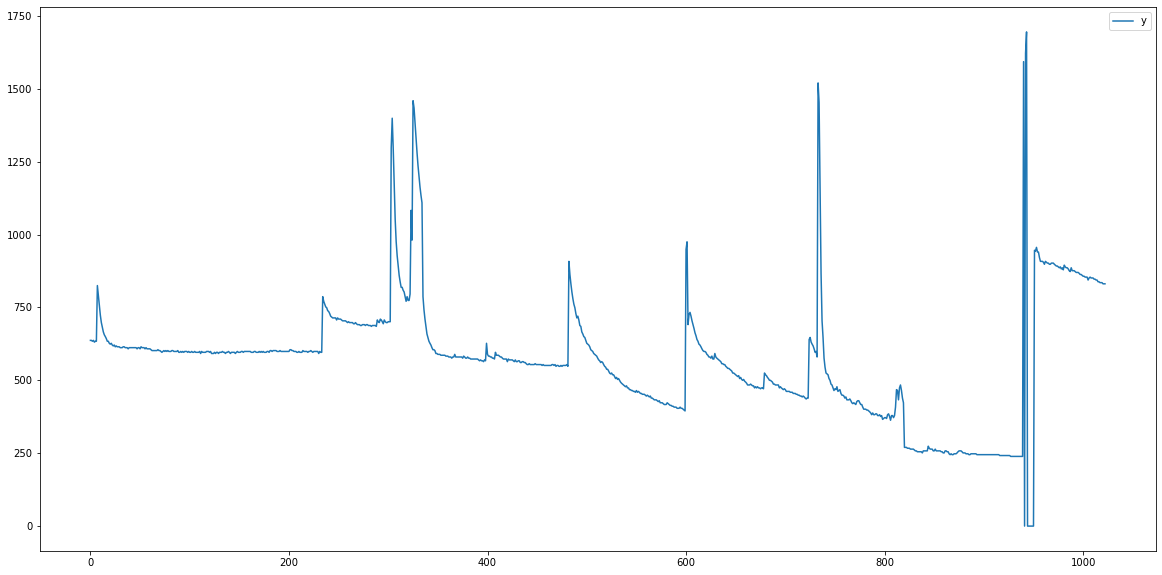

In [6]:
dataframe.plot()

In [7]:
df1=dataframe.reset_index()['y']

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [9]:
df1

array([[0.37581121],
       [0.37581121],
       [0.3740413 ],
       ...,
       [0.49026549],
       [0.49026549],
       [0.49026549]])

In [10]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.70)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [11]:
training_size,test_size

(716, 307)

In [12]:
train_data

array([[0.37581121],
       [0.37581121],
       [0.3740413 ],
       [0.37581121],
       [0.37227139],
       [0.3740413 ],
       [0.3740413 ],
       [0.48672566],
       [0.4660767 ],
       [0.44365782],
       [0.42654867],
       [0.41179941],
       [0.40235988],
       [0.39292035],
       [0.38702065],
       [0.38348083],
       [0.37935103],
       [0.3740413 ],
       [0.3740413 ],
       [0.3699115 ],
       [0.36814159],
       [0.3699115 ],
       [0.36637168],
       [0.36460177],
       [0.36637168],
       [0.36283186],
       [0.36460177],
       [0.36283186],
       [0.36283186],
       [0.36283186],
       [0.36106195],
       [0.36106195],
       [0.36106195],
       [0.36283186],
       [0.36283186],
       [0.36106195],
       [0.36106195],
       [0.36106195],
       [0.35870206],
       [0.36106195],
       [0.36106195],
       [0.36106195],
       [0.36106195],
       [0.36106195],
       [0.36106195],
       [0.36106195],
       [0.36106195],
       [0.358

In [13]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [14]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [15]:
print(X_train.shape), print(y_train.shape)

(615, 100)
(615,)


(None, None)

In [16]:
print(X_test.shape), print(ytest.shape)

(206, 100)
(206,)


(None, None)

In [17]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [18]:
model=Sequential()
model.add(LSTM(100,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(70,return_sequences=True))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(20,return_sequences=True))
model.add(LSTM(10))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 70)           47880     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 50)           24200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 20)           5680      
_________________________________________________________________
lstm_4 (LSTM)                (None, 10)                1240      
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 119,811
Trainable params: 119,811
Non-trainable params: 0
__________________________________________________

In [20]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=len(X_train)-1,verbose=1)


Epoch 1/200
2/2 [==============================] - 11s 2s/step - loss: 0.1420 - val_loss: 0.0413
Epoch 2/200
2/2 [==============================] - 2s 396ms/step - loss: 0.0277 - val_loss: 0.0258
Epoch 3/200
2/2 [==============================] - 2s 410ms/step - loss: 0.0067 - val_loss: 0.0265
Epoch 4/200
2/2 [==============================] - 2s 395ms/step - loss: 0.0063 - val_loss: 0.0269
Epoch 5/200
2/2 [==============================] - 2s 392ms/step - loss: 0.0063 - val_loss: 0.0282
Epoch 6/200
2/2 [==============================] - 2s 398ms/step - loss: 0.0076 - val_loss: 0.0258
Epoch 7/200
2/2 [==============================] - 2s 393ms/step - loss: 0.0055 - val_loss: 0.0250
Epoch 8/200
2/2 [==============================] - 2s 394ms/step - loss: 0.0054 - val_loss: 0.0256
Epoch 9/200
2/2 [==============================] - 2s 396ms/step - loss: 0.0069 - val_loss: 0.0261
Epoch 10/200
2/2 [==============================] - 2s 402ms/step - loss: 0.0079 - val_loss: 0.0250
Epoch 11/20

2/2 [==============================] - 2s 386ms/step - loss: 0.0059 - val_loss: 0.0239
Epoch 84/200
2/2 [==============================] - 2s 388ms/step - loss: 0.0064 - val_loss: 0.0239
Epoch 85/200
2/2 [==============================] - 2s 390ms/step - loss: 0.0063 - val_loss: 0.0235
Epoch 86/200
2/2 [==============================] - 2s 386ms/step - loss: 0.0054 - val_loss: 0.0236
Epoch 87/200
2/2 [==============================] - 2s 390ms/step - loss: 0.0049 - val_loss: 0.0246
Epoch 88/200
2/2 [==============================] - 2s 386ms/step - loss: 0.0055 - val_loss: 0.0250
Epoch 89/200
2/2 [==============================] - 2s 381ms/step - loss: 0.0059 - val_loss: 0.0239
Epoch 90/200
2/2 [==============================] - 2s 393ms/step - loss: 0.0051 - val_loss: 0.0233
Epoch 91/200
2/2 [==============================] - 2s 381ms/step - loss: 0.0050 - val_loss: 0.0234
Epoch 92/200
2/2 [==============================] - 2s 387ms/step - loss: 0.0057 - val_loss: 0.0236
Epoch 93/200


2/2 [==============================] - 2s 373ms/step - loss: 0.0063 - val_loss: 0.0280
Epoch 165/200
2/2 [==============================] - 2s 378ms/step - loss: 0.0127 - val_loss: 0.0244
Epoch 166/200
2/2 [==============================] - 2s 388ms/step - loss: 0.0074 - val_loss: 0.0227
Epoch 167/200
2/2 [==============================] - 2s 388ms/step - loss: 0.0049 - val_loss: 0.0246
Epoch 168/200
2/2 [==============================] - 2s 388ms/step - loss: 0.0073 - val_loss: 0.0265
Epoch 169/200
2/2 [==============================] - 2s 380ms/step - loss: 0.0095 - val_loss: 0.0271
Epoch 170/200
2/2 [==============================] - 2s 380ms/step - loss: 0.0098 - val_loss: 0.0268
Epoch 171/200
2/2 [==============================] - 2s 379ms/step - loss: 0.0087 - val_loss: 0.0260
Epoch 172/200
2/2 [==============================] - 2s 385ms/step - loss: 0.0064 - val_loss: 0.0268
Epoch 173/200
2/2 [==============================] - 2s 374ms/step - loss: 0.0053 - val_loss: 0.0287
Epoc

In [21]:
### Lets Do the prediction and check performance metrics
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error

test_predict=model.predict(X_test)
test_predict=scaler.inverse_transform(test_predict)
mse = mean_squared_error(ytest,test_predict)
mse

328016.6870254749

In [22]:
x_input=test_data[0:time_step].reshape(1,-1)
x_input.shape

(1, 100)

In [23]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [24]:
temp_input

[0.26312684365781713,
 0.26135693215339234,
 0.26312684365781713,
 0.26135693215339234,
 0.25899705014749264,
 0.25722713864306784,
 0.25899705014749264,
 0.25899705014749264,
 0.3775811209439528,
 0.3817109144542773,
 0.3722713864306785,
 0.368141592920354,
 0.3646017699115044,
 0.35870206489675516,
 0.35162241887905604,
 0.35339233038348083,
 0.3421828908554572,
 0.8967551622418879,
 0.8572271386430679,
 0.6861356932153392,
 0.511504424778761,
 0.4153392330383481,
 0.3817109144542773,
 0.3398230088495575,
 0.3215339233038348,
 0.30973451327433627,
 0.3079646017699115,
 0.30619469026548674,
 0.29852507374631265,
 0.2949852507374631,
 0.2873156342182891,
 0.2855457227138643,
 0.279646017699115,
 0.2743362831858407,
 0.2778761061946903,
 0.2761061946902655,
 0.2820058997050148,
 0.27256637168141595,
 0.2743362831858407,
 0.2761061946902655,
 0.26843657817109146,
 0.26489675516224187,
 0.26489675516224187,
 0.26312684365781713,
 0.25899705014749264,
 0.26135693215339234,
 0.2554572271386

In [25]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=time_step
i=0
while(i<7):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.3265989]
101
1 day input [0.26135693 0.26312684 0.26135693 0.25899705 0.25722714 0.25899705
 0.25899705 0.37758112 0.38171091 0.37227139 0.36814159 0.36460177
 0.35870206 0.35162242 0.35339233 0.34218289 0.89675516 0.85722714
 0.68613569 0.51150442 0.41533923 0.38171091 0.33982301 0.32153392
 0.30973451 0.3079646  0.30619469 0.29852507 0.29498525 0.28731563
 0.28554572 0.27964602 0.27433628 0.27787611 0.27610619 0.2820059
 0.27256637 0.27433628 0.27610619 0.26843658 0.26489676 0.26489676
 0.26312684 0.25899705 0.26135693 0.25545723 0.25545723 0.25545723
 0.25722714 0.25368732 0.24955752 0.24778761 0.24955752 0.24778761
 0.2460177  0.2519174  0.25368732 0.25368732 0.24955752 0.2460177
 0.2460177  0.24070796 0.23657817 0.23657817 0.23657817 0.23480826
 0.23480826 0.23303835 0.23126844 0.22890855 0.22536873 0.22890855
 0.22536873 0.22536873 0.22713864 0.22713864 0.22359882 0.22359882
 0.22536873 0.22182891 0.22359882 0.2159292  0.21769912 0.21946903
 0.21946903 0.21769912 0.22536873 0.

In [26]:
final_pred = scaler.inverse_transform(lst_output)
final_pred

array([[553.58515665],
       [554.55009297],
       [555.94632581],
       [557.83260405],
       [560.23630679],
       [563.14717948],
       [566.51859686]])

In [27]:
forecasting={
    
    'Day-1':final_pred[0][0],
    'Day-2':final_pred[1][0],
    'Day-3':final_pred[2][0],
    'Day-4':final_pred[3][0],
    'Day-5':final_pred[4][0],
    'Day-6':final_pred[5][0],
    'Day-7':final_pred[6][0],
    'MSE': mse
}

In [28]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import db
cred = credentials.Certificate("../config/sensors-forecasting-fc27d-firebase-adminsdk-krgvi-403182645e.json")
firebase_admin.initialize_app(cred,{'databaseURL':'https://sensors-forecasting-fc27d-default-rtdb.firebaseio.com/'})
ref = db.reference("/Models/LSTM")
upload_ref = ref.child('Temperature')
upload_ref.update(forecasting)